### Validando a detecção de anomalias para a feature "Novos distribuidores"

**Issue**: [#60](https://github.com/lappis-unb/salic-ml/issues/60)

### Features Extracted:

- https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira

#### Recarregar automaticamente os módulos

### Planila comprovação

SQL Query: https://github.com/lappis-unb/salic-ml/blob/master/data/scripts/planilha_comprovacao2.sql


In [1]:
%load_ext autoreload
%autoreload 2

### Importing data

### FEATURES 
    - Novos distribuidores

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv
from salicml.utils.utils import debug

PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

/home/mandala/.pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mandala/.pyenv/versions/3.6.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Dataset de comprovação

In [3]:
dt_comprovacao_name = 'planilha_comprovacao_2.csv'

usecols = ['PRONAC', 'nrCNPJCPF', 'idPlanilhaAprovacao']
dt_comprovacao = read_csv(dt_comprovacao_name, usecols=usecols)
display(dt_comprovacao.columns)
dt_comprovacao.head()

Index(['PRONAC', 'idPlanilhaAprovacao', 'nrCNPJCPF'], dtype='object')

,PRONAC,idPlanilhaAprovacao,nrCNPJCPF
0,1012121,18552,13751832000191
1,1012121,18553,50618057000127
2,1012121,18554,1118139000105
3,1012121,18555,11049176000154
4,1012121,18556,50618057000127


### Dataset de aprovação

In [4]:
dt_aprovacao_name = 'planilha_orcamentaria.csv'

usecols = ['Item', 'DataProjeto', 'idPlanilhaAprovacao']

dt_aprovacao = read_csv(dt_aprovacao_name, usecols=usecols)
display(dt_aprovacao.columns)
dt_aprovacao.head()

Index(['idPlanilhaAprovacao', 'Item', 'DataProjeto'], dtype='object')

,idPlanilhaAprovacao,Item,DataProjeto
0,50109,Montagem e desmontagem,2009-06-26 09:46:54
1,239572,Locação de Piano,2010-05-06 10:49:13
2,239599,Programa,2010-05-06 10:49:13
3,86608,Transporte Local / Locação de Automóvel / Comb...,2010-12-21 17:09:22
4,11387,Confecção de painéis explicativos,2009-07-27 08:40:04


In [5]:
dt_merge = dt_comprovacao.merge(dt_aprovacao, on='idPlanilhaAprovacao', how='inner')
dt_merge.sort_values(by=['DataProjeto'], inplace=True)
dt_merge.head()

,PRONAC,idPlanilhaAprovacao,nrCNPJCPF,Item,DataProjeto
195,1011390,25416,80303837000149,Refeição,2010-11-26 14:17:57
205,1011390,25419,81667636000193,Refeição,2010-11-26 14:17:57
204,1011390,25418,3610810000158,Refeição,2010-11-26 14:17:57
203,1011390,25418,3029911000130,Refeição,2010-11-26 14:17:57
202,1011390,25418,11169220000160,Refeição,2010-11-26 14:17:57


### Dados de teste e treino

In [6]:
from sklearn.model_selection import train_test_split


all_pronacs = dt_merge.PRONAC.unique()
pronacs_train, pronacs_test = train_test_split(all_pronacs, test_size=0.5)


dt_train = dt_merge[dt_merge['PRONAC'].isin(pronacs_train)]
dt_test = dt_merge[dt_merge['PRONAC'].isin(pronacs_test)]

In [7]:
print('pronacs_train = {}'.format(pronacs_train))
print('pronacs_test = {}'.format(pronacs_test))

assert (dt_train.shape[0] + dt_test.shape[0]) == dt_merge.shape[0]

display(dt_train.head())
display(dt_test.head())

pronacs_train = [ 158567  155366  162520 ...  158679 1114823  133632]
pronacs_test = [154358 149614 164674 ... 113762 150188 161910]


,PRONAC,idPlanilhaAprovacao,nrCNPJCPF,Item,DataProjeto
195,1011390,25416,80303837000149,Refeição,2010-11-26 14:17:57
205,1011390,25419,81667636000193,Refeição,2010-11-26 14:17:57
204,1011390,25418,3610810000158,Refeição,2010-11-26 14:17:57
203,1011390,25418,3029911000130,Refeição,2010-11-26 14:17:57
202,1011390,25418,11169220000160,Refeição,2010-11-26 14:17:57


,PRONAC,idPlanilhaAprovacao,nrCNPJCPF,Item,DataProjeto
343,110023,68555,8919480000109,Projeto Arquitetônico de Restauro,2011-01-03 12:57:19
327,110023,68548,7219739000138,Projeto Arquitetônico,2011-01-03 12:57:19
342,110023,68555,7219739000138,Projeto Arquitetônico de Restauro,2011-01-03 12:57:19
341,110023,68555,7219739000138,Projeto Arquitetônico de Restauro,2011-01-03 12:57:19
340,110023,68553,7219739000138,Projeto de iluminação,2011-01-03 12:57:19


In [8]:
def debug(a, x):
    print('{} = {}'.format(a, x))

# Estatísticas sobre a base de dados

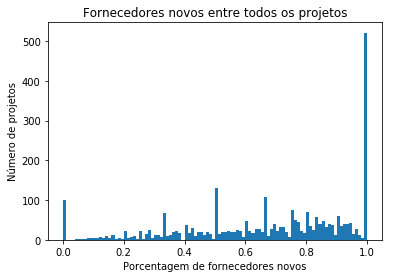

mean = 0.6827814896184252
std = 0.274710639605128


,0
count,2795.000000
mean,0.682781
std,0.274760
min,0.000000
25%,0.500000
50%,0.740385
75%,0.919459
max,1.000000


In [9]:
def init_hist(dt=None):
    if dt is None:
        dt = dt_merge
        
    providers = set()
    pronac_providers = {}
    pronac_new_providers = {}
    
    for index, row in dt.iterrows():
        cnpj = row['nrCNPJCPF']
        pronac = row['PRONAC']
        
        pronac_providers.setdefault(pronac, set())
        pronac_new_providers.setdefault(pronac, 0)
        
        pronac_providers[pronac].add(cnpj)
        if cnpj not in providers:
            pronac_new_providers[pronac] += 1
            providers.add(cnpj)
    
    arr = [pronac_new_providers[x] / len(pronac_providers[x]) for x in pronac_providers]
    mean = np.mean(arr)
    std = np.std(arr)
    
    #debug('providers', providers)
    #debug('pronac_providers', pronac_providers)
    #debug('pronac_new_providers', pronac_new_providers)
    #debug('arr', arr)
    
    plt.hist(arr, bins = 100)
    plt.xlabel('Porcentagem de fornecedores novos')
    plt.ylabel('Número de projetos')
    plt.title('Fornecedores novos entre todos os projetos')
    plt.show()
    return arr, mean, std

porcentages, mean, std = init_hist(dt=dt_merge)

debug('mean', mean)
debug('std', std)
display(pd.DataFrame(np.array(porcentages)).describe())

In [10]:
p = 75.0
while p < 100.0:
    p += 2.5
    
    percentile = np.percentile(porcentages, p)
    print('percentile({}) = {}'.format(p, percentile))

percentile(77.5) = 0.9375
percentile(80.0) = 0.9611965811965814
percentile(82.5) = 1.0
percentile(85.0) = 1.0
percentile(87.5) = 1.0
percentile(90.0) = 1.0
percentile(92.5) = 1.0
percentile(95.0) = 1.0
percentile(97.5) = 1.0
percentile(100.0) = 1.0


# Comentários sobre os dados

A maioria (75%) dos projetos possuem até 91% de fornecedores novos, ou seja, fornecedores que não estiveram em nenhum outro projeto que chegou à fase de Análise Financeira. Na prática a noção de "outlier" fica mais complicada. Por exemplo: se consideramos que um projeto é outlier se 100% de seus fornecedores são "novos" (nunca antes vistos), então `19%` da base de dados seria classificada como "outlier". Mesmo com um valor extremo (1.0) para classificar um projeto como outlier, muitos projetos (`19%`) seriam outliers.  

### Preparando o treino

In [11]:
def get_providers(pronac):
    """Get distinct providers (CNPJS) for the given pronac"""
    items = dt_comprovacao[dt_comprovacao.PRONAC == pronac]
    cnpjs = items['nrCNPJCPF'].unique()
    return cnpjs

def are_known_cnpjs(pronac, providers, dt=None):
    """Assumes that each element in providers is unique.
       The i-th position of the return value is True
       if and only if providers[i] is a new provider
    """
    
    if dt is None:
        dt = dt_comprovacao
        
    items = dt[dt.PRONAC != pronac]
    cnpjs = items['nrCNPJCPF'].unique()
    return np.isin(providers, cnpjs)
    
p = np.random.choice(dt_comprovacao.PRONAC.values)
providers = get_providers(p)
response = are_known_cnpjs(p, providers)

### O problema de assumir que a distribuição é Gaussiana

A partir do histograma plotado nas células acima ficou claro que a distribuição não parece com uma Gaussiana. Um segundo problema é que a abordagem de comparar `x` com `média + c * desvio_padrao` é que este valor pode ser sempre maior que `1.0`, enquanto `0.0 <= x <= 1.0` para todos os `x`, já que estamos comparando a porcentagens de fornecedores novos entre todos os fornecedores do projeto. Ou seja, Os projetos nunca seriam considerados outliers. 

In [12]:
def is_pronac_outlier(pronac, percentile, dt):
    providers = get_providers(pronac)
    
    total_providers = len(providers)
    total_new_providers = total_providers - np.sum(are_known_cnpjs(pronac, providers, dt=dt))
    
    new_percentage = total_new_providers / total_providers
    outlier = new_percentage > percentile
    return outlier, new_percentage

pronac = np.random.choice(dt_test.PRONAC.values)
debug('pronac', pronac)
is_pronac_outlier(pronac, percentile = 0.95, dt=dt_test)

pronac = 163798


(False, 0.7738095238095238)

# Treino

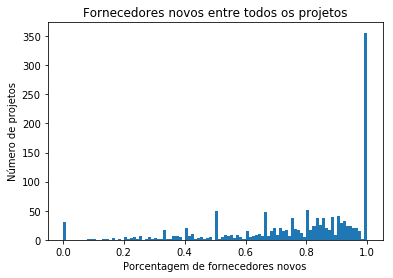

percentile(70) = 0.95


In [13]:
porcentages, mean, std = init_hist(dt=dt_train)
percentile_quota = 70
percentile = np.percentile(porcentages, percentile_quota)

print('percentile({}) = {}'.format(percentile_quota, percentile))

# Teste

In [14]:
pronacs_test = dt_test.PRONAC.unique()

outlier_arr = []
porcentages_arr = []

for i, pronac in enumerate(pronacs_test):
    try:
        outlier, new_porcentage = is_pronac_outlier(int(pronac), percentile=percentile, dt=dt_test)
        outlier_arr.append(1.0 if outlier else 0.0)
        porcentages_arr.append(new_porcentage)
    except ValueError as err:
        print(err)
    
describe = pd.DataFrame(outlier_arr).describe()
display(describe)

,0
count,1398.000000
mean,0.100143
std,0.300298
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000
